In [ ]:
!pip install filterpy

In [53]:
import numpy as np
import pandas as pd
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt


def smooth(y, box_pts):
    """
    Smoothing function.
    :param y: np.array.
    :param box_pts: window (int).
    :return: smoother np.array.
    """
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def preprocess_data(data_country):
    """
    Compute I and R from cumulative Cases, Recovered and Deaths data.
    :param data_country: fetched data like John Hopkins Covid-19 (pd.DataFrame).
    :return: list of tuple daily (I, R).
    """
    global DATA_SMOOTHING_WINDOW, CASES_CONSIDERED
    return [(c - (r + d), r + d) for c, d, r
            in zip(data_country['Cases'].rolling(DATA_SMOOTHING_WINDOW).mean(),
                   data_country['Dead'].rolling(DATA_SMOOTHING_WINDOW).mean(),
                   data_country['Recovered'].rolling(DATA_SMOOTHING_WINDOW).mean())
            if c > CASES_CONSIDERED]


def fx(x, delta_t):
    """
    Equations from the SEIR model.

    dS = - (R0 / T_inf) * (S / N) * I * dt
    dE = ((R0 / T_inf) * (S / N) * I - E / T_inc) * dt
    dI = (E / T_inc - beta * I) * dt
    dR = beta * I * dt
    dR0[t] = ddR0[t-1] * dt
    ddR0[t] ~ N(0, q ** 2)

    :param x: t-1 state vector.
    :param delta_t: time delta.
    :return: state vector at t.
    """

    global t_inc, t_inf, N

    S = x[0]
    E = x[2] if x[2] >= 0 else 0
    I = x[4]
    R0 = x[8] if x[8] >= 0 else 0

    dS_temp = (R0 / t_inf) * (S / N) * I * delta_t
    dE_temp = (E / t_inc) * delta_t

    dS = - dS_temp
    dE = dS_temp - dE_temp
    dR = (I / t_inf) * delta_t
    dI = dE_temp - dR
    dR0 = x[9] * delta_t
    ddR0 = x[10] * delta_t

    x[1] = dS
    x[3] = dE
    x[5] = dI
    x[7] = dR
    x[9] = ddR0

    return x + np.array([dS, 0, dE, 0, dI, 0, dR if dR > 0 else 0, 0, dR0, ddR0, 0, 0], dtype=float)


def hx(x):
    """
    Measurement from state vector.
    :param x: state vector.
    :return: measured vector.
    """
    return np.array([x[4], x[6]])


# My data is using french country names.
POPULATIONS = {
    "AL":   4.9e6,
    "SC":  5.14e6,
    "NC":   10.5e6,
}

CASES_CONSIDERED = 30
DATA_SMOOTHING_WINDOW = 1
FORECAST_DAYS = 5
AVERAGE_R0_WINDOW = 7
SIGMA_CONSIDERED = 3

# From literature:
# - https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article.
# - https://www.ncbi.nlm.nih.gov/pubmed/32097725.
# - https://gabgoh.github.io/COVID/index.html.
t_inf = 2.9
t_inc = 5.2
R0_init = 5.7  # Not very sensible to current or previous estimate of R0.

# Unscented Kalman Filter (UKF) setup.
dt = 1
dim_x, dim_z = 12, 2
z_std = (1e-2, 5e-3)
var_q = 5e-2
points = MerweScaledSigmaPoints(dim_x, alpha=1e-3, beta=2, kappa=1)

In [52]:
# df.replace([np.inf, -np.inf], np.nan)
# df['Dead'].replace(np.nan, 0, inplace=True)
# df['Cases'].replace(np.nan, 0, inplace=True)
# df['Recovered'].replace(np.nan, 0, inplace=True)

df = pd.read_csv('https://covidtracking.com/data/download/all-states-history.csv')
df = df[['date', 'state', 'death', 'positive','recovered']]
df.columns = ['date', 'state', 'Dead', 'Cases','Recovered']
df = df[(df['date'] > '2020-05-21') & (df['date'] < '2020-08-21')]
data = df.sort_values(['state','date'],ascending=[True,True])
data

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,state,Dead,Cases,Recovered
12040,2020-05-22,AK,10.0,406.0,356.0
11984,2020-05-23,AK,10.0,410.0,358.0
11928,2020-05-24,AK,10.0,410.0,358.0
11872,2020-05-25,AK,10.0,411.0,361.0
11816,2020-05-26,AK,10.0,413.0,362.0
...,...,...,...,...,...
7279,2020-08-16,WY,30.0,3286.0,2668.0
7223,2020-08-17,WY,33.0,3331.0,2699.0
7167,2020-08-18,WY,34.0,3363.0,2759.0
7111,2020-08-19,WY,34.0,3430.0,2786.0


AL
SC
NC


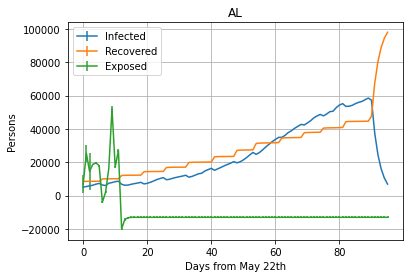

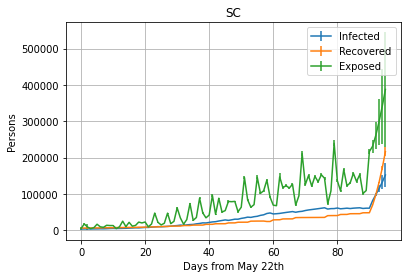

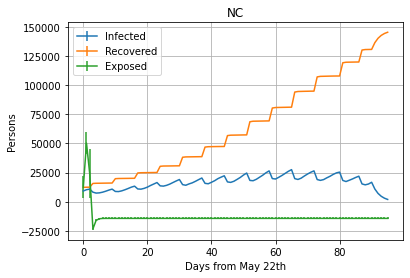

In [54]:
# Run UKF by populations.
results = list()
predicts = list()
for k, v in POPULATIONS.items():
    print(k)

    N = v

    data_country = data[data["state"] == k]

    zs = preprocess_data(data_country)

    # SETUP UKF.
    kf = UnscentedKalmanFilter(dim_x=dim_x, dim_z=dim_z, dt=dt, fx=fx, hx=hx, points=points)

    # ~ Inital conditions.
    kf.x = np.array([v, 0,
                      0, 0,
                      zs[0][0], 0,
                      zs[0][1], 0,
                      R0_init, 0, 0, 0])

    # Noise setup
    kf.P *= 1e0  # factor on uncertainty of initial condition.
    kf.R = np.diag([z ** 2 for z in list(z_std)])
    kf.Q = Q_discrete_white_noise(dim=dim_z, dt=dt, var=var_q ** 2, block_size=int(dim_x / 2))

    # RUN UKF
    # Derive all hidden variables from past and present.
    R = list()
    R0 = list()
    for z in zs:

        kf.predict()
        kf.update(z)

        x, y = kf.x, kf.P
        R0.append(x[8])
        R.append((x, y))

    # Predict future.
    for i in range(FORECAST_DAYS):

        # Keep R0 constant for predictions.
        kf.x[8] = np.mean(R0[-AVERAGE_R0_WINDOW:])
        kf.x[9] = 0
        kf.x[10] = 0

        try:
            kf.predict()
            x, y = kf.x, kf.P
            R.append((x, y))
        except np.linalg.LinAlgError:
            print("Cannot predict %d" % i)

    results.append(R)


# Plot population curves I, E and R.
for r, t in zip(results, POPULATIONS.keys()):
    xs = range(len(r))

    I = smooth([a[0][4] for a in r], DATA_SMOOTHING_WINDOW)
    sI = [SIGMA_CONSIDERED * np.sqrt(a[1][4, 4]) for a in r]

    R = smooth([a[0][6] for a in r], DATA_SMOOTHING_WINDOW)
    sR = [SIGMA_CONSIDERED * np.sqrt(a[1][6, 6]) for a in r]

    E = smooth([a[0][2] for a in r], DATA_SMOOTHING_WINDOW)
    sE = [SIGMA_CONSIDERED * np.sqrt(a[1][2, 2]) for a in r]

    plt.errorbar(x=xs, y=I, yerr=sI)
    plt.errorbar(x=xs, y=R, yerr=sR)
    plt.errorbar(x=xs, y=E, yerr=sE)

    plt.title(t)
    plt.xlabel("Days from May 22th")
    plt.ylabel("Persons")
    plt.legend(["Infected", "Recovered", "Exposed"])
    plt.grid(True)
    plt.show()

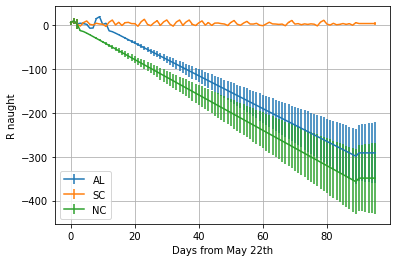

In [55]:
# Plot R0.
for r, t in zip(results, POPULATIONS.keys()):
    xs = range(len(r))
    R0 = smooth([a[0][8] for a in r], DATA_SMOOTHING_WINDOW)
    sR0 = [SIGMA_CONSIDERED * np.sqrt(a[1][8, 8]) for a in r]
    plt.errorbar(x=xs, y=R0, yerr=sR0)

plt.legend(POPULATIONS.keys())
plt.xlabel("Days from May 22th")
plt.ylabel("R naught")
plt.grid(True)
plt.show()